In [19]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, MaxPooling2D ,Conv2D, Flatten, GlobalMaxPool2D
from tensorflow.keras.applications import Xception, mobilenet_v3, vgg16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import os
import matplotlib.pyplot as plt
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras import layers

In [20]:
baseDir = '/kaggle/input/eyepacs-airogs-light/release-crop/release-crop/'
testDir = baseDir + 'test'
trainDir = baseDir + 'train'
validDir = baseDir + 'validation'

train_NRG = os.path.join(trainDir, 'NRG')
train_RG = os.path.join(trainDir, 'RG')

valid_NRG = os.path.join(validDir, 'NRG')
valid_RG = os.path.join(validDir, 'RG')

In [21]:
img_width, img_height = 224,224
batch_size = 32
num_epochs = 50

In [22]:
val_datagen = ImageDataGenerator(rescale = 1. / 255)
train_datagen = ImageDataGenerator(#rotation_range=90,
                                    #brightness_range=[0.1, 0.7],
                                     width_shift_range=0.5,
                                     height_shift_range=0.5,
                                     horizontal_flip=True,
                                     vertical_flip=True,
                                     #validation_split=0.15,
                                    #preprocessing_function=preprocess_input,
                                    zoom_range=0.15,
                                    fill_mode="constant",
                                    cval=0.1,
                                    rescale = 1. / 255)
                                    
                                    



test_datagen = ImageDataGenerator(rescale = 1. / 255)
                                    


In [23]:
train_generator = train_datagen.flow_from_directory(
    directory=trainDir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle = True
)

validation_generator = val_datagen.flow_from_directory(
    directory=validDir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle = False
)

test_generator =  test_datagen.flow_from_directory(
    testDir,
    batch_size=batch_size,
    class_mode='binary',
    target_size=(img_width, img_height),
    shuffle = False
)

Found 5000 images belonging to 2 classes.
Found 540 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [24]:
lr_reduce = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.25,
                              patience=3,
                              verbose=1,
                              mode='auto',
                              min_lr=0)

early_stopping = EarlyStopping(monitor='val_loss', # val_loss değerindeki değişimleri kontrol et
                               patience = 15, # en az belirtilen epoch boyunca iyileşme olmazsa durdur
                               mode='auto',
                               min_delta = 0.001)


base_model = tf.keras.applications.xception.Xception(weights='imagenet', include_top=False,
                                                        input_shape=(img_width, img_height, 3), 
                                                        classifier_activation='sigmoid')
base_model.trainable = True
#for layer in base_model.layers[:108]:
 #   layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
          loss='binary_crossentropy',
          metrics = ['accuracy'])
history = model.fit(
    train_generator,
    epochs=num_epochs,
    validation_data=validation_generator,
    callbacks=[lr_reduce, early_stopping],
    verbose = 2
)


Epoch 1/50
157/157 - 91s - loss: 0.6130 - accuracy: 0.6608 - val_loss: 0.4890 - val_accuracy: 0.7981 - lr: 0.0010 - 91s/epoch - 581ms/step
Epoch 2/50
157/157 - 61s - loss: 0.4876 - accuracy: 0.7696 - val_loss: 0.8867 - val_accuracy: 0.7333 - lr: 0.0010 - 61s/epoch - 387ms/step
Epoch 3/50
157/157 - 61s - loss: 0.4302 - accuracy: 0.8080 - val_loss: 0.5901 - val_accuracy: 0.8278 - lr: 0.0010 - 61s/epoch - 387ms/step
Epoch 4/50

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
157/157 - 61s - loss: 0.3934 - accuracy: 0.8282 - val_loss: 0.8640 - val_accuracy: 0.8074 - lr: 0.0010 - 61s/epoch - 389ms/step
Epoch 5/50
157/157 - 62s - loss: 0.3567 - accuracy: 0.8398 - val_loss: 0.2747 - val_accuracy: 0.9000 - lr: 2.5000e-04 - 62s/epoch - 396ms/step
Epoch 6/50
157/157 - 61s - loss: 0.3210 - accuracy: 0.8550 - val_loss: 0.2723 - val_accuracy: 0.8852 - lr: 2.5000e-04 - 61s/epoch - 389ms/step
Epoch 7/50
157/157 - 62s - loss: 0.3127 - accuracy: 0.8692 - val_loss: 0.2528 - v

32/32 - 3s - loss: 0.1936 - accuracy: 0.9230 - 3s/epoch - 98ms/step


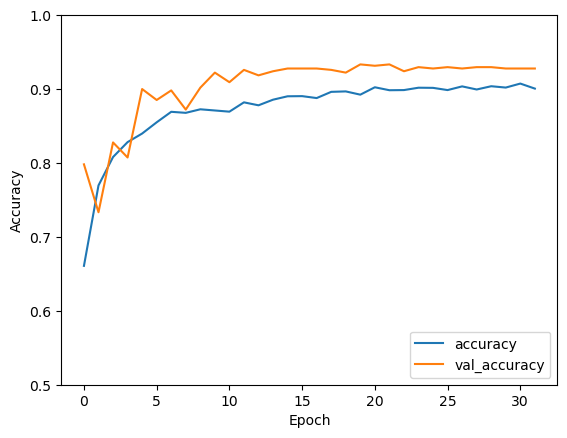

In [25]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_generator, verbose=2)

In [26]:
lr_reduce = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.25,
                              patience=3,
                              verbose=1,
                              mode='auto',
                              min_lr=0)

early_stopping = EarlyStopping(monitor='val_loss', # val_loss değerindeki değişimleri kontrol et
                               patience = 15, # en az belirtilen epoch boyunca iyileşme olmazsa durdur
                               mode='auto',
                               min_delta = 0.001)


base_model = tf.keras.applications.resnet50.ResNet50(weights='imagenet', include_top=False,
                                                        input_shape=(img_width, img_height, 3), 
                                                        classifier_activation='sigmoid')
base_model.trainable = True
#for layer in base_model.layers[:108]:
 #   layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)
model1 = Model(inputs=base_model.input, outputs=predictions)

model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
          loss='binary_crossentropy',
          metrics = ['accuracy'])
history = model1.fit(
    train_generator,
    epochs=num_epochs,
    validation_data=validation_generator,
    callbacks=[lr_reduce, early_stopping],
    verbose = 2
)

94765736/94765736 [==============================] - 0s 0us/step
Epoch 1/50
157/157 - 98s - loss: 0.7843 - accuracy: 0.5540 - val_loss: 0.9592 - val_accuracy: 0.5000 - lr: 0.0010 - 98s/epoch - 621ms/step
Epoch 2/50
157/157 - 56s - loss: 0.7059 - accuracy: 0.6176 - val_loss: 1.5250 - val_accuracy: 0.5000 - lr: 0.0010 - 56s/epoch - 355ms/step
Epoch 3/50
157/157 - 56s - loss: 0.6452 - accuracy: 0.6656 - val_loss: 0.6926 - val_accuracy: 0.5019 - lr: 0.0010 - 56s/epoch - 358ms/step
Epoch 4/50
157/157 - 56s - loss: 0.5796 - accuracy: 0.7028 - val_loss: 0.7413 - val_accuracy: 0.5000 - lr: 0.0010 - 56s/epoch - 356ms/step
Epoch 5/50
157/157 - 56s - loss: 0.5393 - accuracy: 0.7282 - val_loss: 0.7619 - val_accuracy: 0.4907 - lr: 0.0010 - 56s/epoch - 357ms/step
Epoch 6/50

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
157/157 - 55s - loss: 0.5228 - accuracy: 0.7350 - val_loss: 1.0756 - val_accuracy: 0.5056 - lr: 0.0010 - 55s/epoch - 353ms/step
Epoch 7/50
157/157 - 56s

32/32 - 3s - loss: 0.2506 - accuracy: 0.8850 - 3s/epoch - 100ms/step


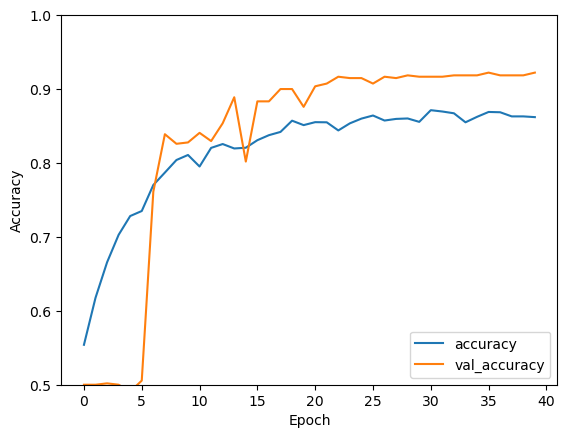

In [27]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model1.evaluate(test_generator, verbose=2)

In [28]:
lr_reduce = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.25,
                              patience=3,
                              verbose=1,
                              mode='auto',
                              min_lr=0)

early_stopping = EarlyStopping(monitor='val_loss', # val_loss değerindeki değişimleri kontrol et
                               patience = 15, # en az belirtilen epoch boyunca iyileşme olmazsa durdur
                               mode='auto',
                               min_delta = 0.001)


base_model = tf.keras.applications.densenet.DenseNet169(weights='imagenet', include_top=False,
                                                        input_shape=(img_width, img_height, 3), 
                                                        classifier_activation='sigmoid')
base_model.trainable = True
#for layer in base_model.layers[:108]:
 #   layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)
model2 = Model(inputs=base_model.input, outputs=predictions)

model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
          loss='binary_crossentropy',
          metrics = ['accuracy'])
history = model2.fit(
    train_generator,
    epochs=num_epochs,
    validation_data=validation_generator,
    callbacks=[lr_reduce, early_stopping],
    verbose = 2
)

51877672/51877672 [==============================] - 0s 0us/step
Epoch 1/50
157/157 - 171s - loss: 0.7089 - accuracy: 0.6084 - val_loss: 1.2350 - val_accuracy: 0.5315 - lr: 0.0010 - 171s/epoch - 1s/step
Epoch 2/50
157/157 - 60s - loss: 0.6695 - accuracy: 0.6186 - val_loss: 15.3591 - val_accuracy: 0.4741 - lr: 0.0010 - 60s/epoch - 381ms/step
Epoch 3/50
157/157 - 61s - loss: 0.6306 - accuracy: 0.6540 - val_loss: 1.9169 - val_accuracy: 0.5000 - lr: 0.0010 - 61s/epoch - 386ms/step
Epoch 4/50
157/157 - 60s - loss: 0.6010 - accuracy: 0.6768 - val_loss: 0.9843 - val_accuracy: 0.7444 - lr: 0.0010 - 60s/epoch - 381ms/step
Epoch 5/50
157/157 - 60s - loss: 0.5374 - accuracy: 0.7252 - val_loss: 0.6026 - val_accuracy: 0.7833 - lr: 0.0010 - 60s/epoch - 383ms/step
Epoch 6/50
157/157 - 61s - loss: 0.5048 - accuracy: 0.7502 - val_loss: 0.5662 - val_accuracy: 0.7537 - lr: 0.0010 - 61s/epoch - 385ms/step
Epoch 7/50
157/157 - 61s - loss: 0.5036 - accuracy: 0.7618 - val_loss: 0.4508 - val_accuracy: 0.8111 

32/32 - 3s - loss: 0.2258 - accuracy: 0.9000 - 3s/epoch - 108ms/step


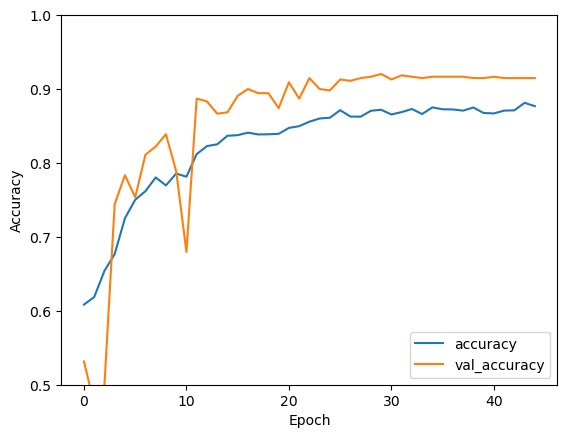

In [29]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model2.evaluate(test_generator, verbose=2)

In [30]:
# import concatenate layer
from tensorflow.keras.layers import Concatenate
from tensorflow.keras import Input

# get list of models
models = [model1, model2, model]

inputX = Input(shape=(224, 224, 3), name='input') # input layer

# get output for each model input
outputs = [model(inputX) for model in models]

# contenate the ouputs
x = Concatenate()(outputs)

# add further layers
x = Dropout(0.5)(x)
x = Dense(64,activation='relu')(x)
output = Dense(1, activation='sigmoid', name='output')(x) # output layer

# create concatenated model
conc_model = Model(inputX, output, name= 'Concatenated_Model')

In [31]:
conc_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
          loss='binary_crossentropy',
          metrics = ['accuracy'])

In [32]:
history = conc_model.fit(
    train_generator,
    epochs=num_epochs,
    validation_data=validation_generator,
    callbacks=[lr_reduce, early_stopping],
    verbose = 2
)


Epoch 1/50
157/157 - 284s - loss: 0.6174 - accuracy: 0.6516 - val_loss: 0.5537 - val_accuracy: 0.7852 - lr: 0.0010 - 284s/epoch - 2s/step
Epoch 2/50
157/157 - 106s - loss: 0.5976 - accuracy: 0.6402 - val_loss: 0.4804 - val_accuracy: 0.8741 - lr: 0.0010 - 106s/epoch - 677ms/step
Epoch 3/50
157/157 - 106s - loss: 0.5953 - accuracy: 0.6402 - val_loss: 0.5584 - val_accuracy: 0.7833 - lr: 0.0010 - 106s/epoch - 678ms/step
Epoch 4/50
157/157 - 107s - loss: 0.5929 - accuracy: 0.6394 - val_loss: 0.4494 - val_accuracy: 0.8481 - lr: 0.0010 - 107s/epoch - 680ms/step
Epoch 5/50
157/157 - 106s - loss: 0.5749 - accuracy: 0.6628 - val_loss: 0.5109 - val_accuracy: 0.8426 - lr: 0.0010 - 106s/epoch - 678ms/step
Epoch 6/50
157/157 - 107s - loss: 0.5867 - accuracy: 0.6482 - val_loss: 0.4997 - val_accuracy: 0.8630 - lr: 0.0010 - 107s/epoch - 679ms/step
Epoch 7/50
157/157 - 106s - loss: 0.5743 - accuracy: 0.6572 - val_loss: 0.4400 - val_accuracy: 0.8389 - lr: 0.0010 - 106s/epoch - 677ms/step
Epoch 8/50
157/1

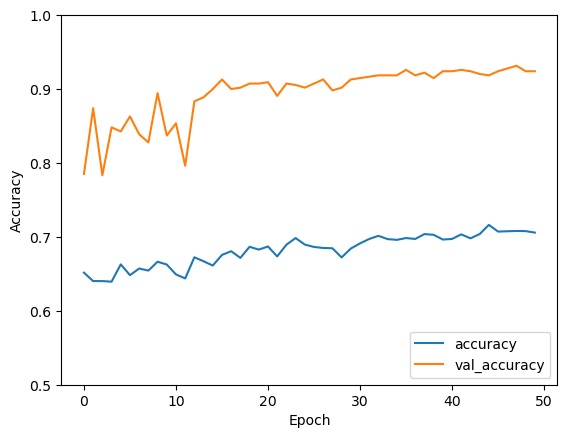

In [33]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [34]:
test_loss, test_acc = conc_model.evaluate(test_generator, verbose=2)

32/32 - 6s - loss: 0.2821 - accuracy: 0.9190 - 6s/epoch - 185ms/step


In [35]:
print(test_acc)

0.9190000295639038
